In [8]:
from zipfile import ZipFile  # working with zipped input
from mlxtend.frequent_patterns import fpgrowth, association_rules  # MBA
from scipy import sparse  # sparse matrices
import numpy as np
import pandas as pd
import os

In [10]:
def preDot(text):
    return text.rsplit('.', 1)[0]

np.random.seed(73)
pd.options.mode.chained_assignment = None
dataDict = {}

for dirname, _, filenames in os.walk('./untitled folder/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        with ZipFile(os.path.join(dirname, filename), 'r') as zipf:
            unzipped_fn = preDot(filename)
            with zipf.open(unzipped_fn) as f:
                dataDict[preDot(unzipped_fn)] = pd.read_csv(f)

train_orders = dataDict['orders'][dataDict['orders']['eval_set'] == 'train'].drop('eval_set', axis=1)
prior_orders = dataDict['orders'][dataDict['orders']['eval_set'] == 'prior'].drop('eval_set', axis=1)
test_orders = dataDict['orders'][dataDict['orders']['eval_set'] == 'test'].drop('eval_set', axis=1)

./untitled folder/order_products__prior.csv.zip
./untitled folder/order_products__train.csv.zip
./untitled folder/aisles.csv.zip
./untitled folder/orders.csv.zip
./untitled folder/departments.csv.zip
./untitled folder/products.csv.zip


In [11]:
small_train = dataDict['order_products__train'][['order_id', 'product_id']]
small_train_split = (small_train[:461543], small_train[461543:461543*2-1], small_train[461543*2-1:])

In [12]:
pivots = []
for df in small_train_split:
    pvt = ~(df.pivot(index='order_id', columns='product_id', values='product_id').isna())
    pivots.append(pvt.astype(pd.SparseDtype(bool)))
del pvt

product_cols = sorted(small_train.product_id.unique())

In [13]:
for i in range(len(pivots)):
    # reindexing to add extra columns and standardize the format for vstack
    # we sparse them again here b/c otherwise we would end up having regular boolean columns
    pivots[i] = pivots[i].reindex(columns=product_cols, fill_value=False).astype(pd.SparseDtype(bool))
    pivots[i] = sparse.csr_matrix(pivots[i])
# concat vertically
pivots = sparse.vstack(pivots)

In [14]:
truth_table = pd.DataFrame(pivots.todense(), index=small_train.order_id.unique(), columns=product_cols)

In [15]:
frequent_itemsets = fpgrowth(truth_table, min_support=5/len(truth_table), use_colnames=True)

In [16]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.8)

In [17]:
print("μ number of consequents:", rules['consequents'].apply(len).mean())
rules

μ number of consequents: 1.0391897394136809


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(47626, 49683, 4605, 21903)",(24852),0.000076,0.142719,0.000069,0.900000,6.306104,0.000058,8.572811
1,"(26209, 49683, 28204, 16797)",(24852),0.000046,0.142719,0.000038,0.833333,5.838985,0.000032,5.143687
2,"(49683, 39275, 48679)",(24852),0.000046,0.142719,0.000038,0.833333,5.838985,0.000032,5.143687
3,"(27104, 49683, 24964, 47766)",(24852),0.000038,0.142719,0.000038,1.000000,7.006782,0.000033,inf
4,"(42265, 40706, 49683, 24852)",(21903),0.000046,0.074568,0.000038,0.833333,11.175474,0.000035,5.552592
...,...,...,...,...,...,...,...,...,...
29467,(26460),(38936),0.000046,0.000099,0.000038,0.833333,8410.833333,0.000038,5.999406
29468,(3458),(24852),0.000053,0.142719,0.000046,0.857143,6.005813,0.000038,6.000968
29469,"(9497, 1134)",(8833),0.000038,0.000114,0.000038,1.000000,8747.266667,0.000038,inf
29470,(15317),(12902),0.000038,0.000122,0.000038,1.000000,8200.562500,0.000038,inf


In [18]:
# selecting out rules that might potentially not be enhancing
rules = rules[rules.lift > 1]

In [19]:
# a simplification of the table
rules_ante_cons = rules[['antecedents', 'consequents']]

In [20]:
baskets = small_train.groupby('order_id')['product_id'].apply(frozenset)
baskets.name = "basket"  # antecedents

In [21]:
recommendations = train_orders.join(baskets, on="order_id")
recommendations["recommendations"] = [frozenset() for _ in range(len(recommendations))]

In [22]:
# computationally-intensive; might require an optimization
for idx, antecedent in enumerate(rules_ante_cons["antecedents"]):
    lookup = antecedent <= recommendations.basket, "recommendations"
    recommendations.loc[lookup] = recommendations.loc[lookup].apply(
        frozenset.union,
        args=(rules_ante_cons.loc[idx, "consequents"],)
    )
# recommendations = recommendations.rename(columns={"antecedents": "basket"})
# this may be changed earlier
recommendations.loc[:, "recommendations"] = recommendations.recommendations - recommendations.basket

In [23]:
non_empty_recs = recommendations[recommendations.recommendations.apply(bool)]
print("1 out of approx.", round(1/(len(non_empty_recs) / len(recommendations))), "transactions will result in a recommendation being suggested to a customer.")
# mapping codes to product names
def map_products(codes):
    if isinstance(codes, pd.Series):
        return codes.apply(map_products)
    return frozenset(map(products.get, codes))

products = dataDict["products"]
products = products.set_index("product_id")["product_name"].to_dict()
non_empty_recs.loc[:, ["basket", "recommendations"]] = non_empty_recs[["basket", "recommendations"]].apply(map_products)
display(non_empty_recs)

1 out of approx. 14 transactions will result in a recommendation being suggested to a customer.


,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,basket,recommendations
78,880375,8,4,1,14,10.0,"(Broccoli Rabe, Organic SprouTofu Silken Tofu,...",(Limes)
82,1094988,9,4,6,10,30.0,(Total 0% with Honey Nonfat Greek Strained Yog...,"(Fat Free Blueberry Yogurt, Total 0% Raspberry..."
948,1019719,62,11,2,12,29.0,"(Organic Baby Spring Mix, Organic Cripps Pink ...",(Bag of Organic Bananas)
1269,613340,86,18,6,12,6.0,"(Organic Diced Tomatoes, Organic Frozen Mango ...","(Organic Hass Avocado, Organic Strawberries)"
1326,2222431,89,21,6,18,6.0,"(Organic Garlic, Almond Milk Strawberry Yogurt...",(Bag of Organic Bananas)
...,...,...,...,...,...,...,...,...
3419876,1695230,206128,16,2,8,30.0,"(Large Lemon, Organic Whole Milk with DHA Omeg...","(Organic Italian Parsley Bunch, Organic Cucumb..."
3419926,458698,206134,4,0,14,30.0,"(Strained Whole-Milk Yogurt Blueberry, Non Fat...",(Bag of Organic Bananas)
3420670,3367945,206188,8,1,21,30.0,"(Light Sour Cream, Grab 'N Go® Cups & Lids 12 ...",(Strawberries)
3420692,2530125,206191,6,0,9,30.0,"(Original Hummus, Muenster Cheese, Sea Salt Fi...","(Organic Avocado, Organic Grape Tomatoes)"


In [26]:
def mba_diagram(sample_basket, sample_recommendation):
    import matplotlib.pyplot as plt

    def get_text_box_coords(txt):
        we = plt.Text.get_window_extent(txt, renderer=fig.canvas.get_renderer())
        return ax.transAxes.inverted().transform(we)
    def get_rightmost_vmid(box):
        return box[1][0], (box[0][1] + box[1][1]) / 2

    fig, ax = plt.subplots(figsize=(20,10))
    title = ax.set_title("An illustration of a recommendation system for a sample customer basket\n(basket ← suggestion)", fontsize=18)
    ax.axis('off')
    basket_txt = ax.text(.05, .95, sample_basket, ha='left', va='top', wrap=True,size=12,
                  bbox=dict(boxstyle='round,pad=1', fc='w', ec='lightblue'))

    basket_rightmost, basket_vmid = get_rightmost_vmid(get_text_box_coords(basket_txt))
    arrow_txt = ax.text(
        basket_rightmost*1.4, basket_vmid, "Add", ha="center", va="center", size=35,
        bbox=dict(boxstyle="larrow,pad=0.6", fc="blue", ec="g", lw=2))
    arrow_rightmost, arrow_vmid = get_rightmost_vmid(get_text_box_coords(arrow_txt))

    recommendation_txt = ax.text(arrow_rightmost * 1.14, arrow_vmid, sample_recommendation, ha='left', va='top', wrap=True, fontsize=25,
                  bbox=dict(boxstyle='round,pad=1', fc='w', ec='r'))
    recommendation_txt_pos = recommendation_txt.get_position()
    recommendation_txt.set_position((
        recommendation_txt_pos[0],
        recommendation_txt_pos[1] + (get_text_box_coords(recommendation_txt)[1][1]-get_text_box_coords(recommendation_txt)[0][1]) / 2
    ))

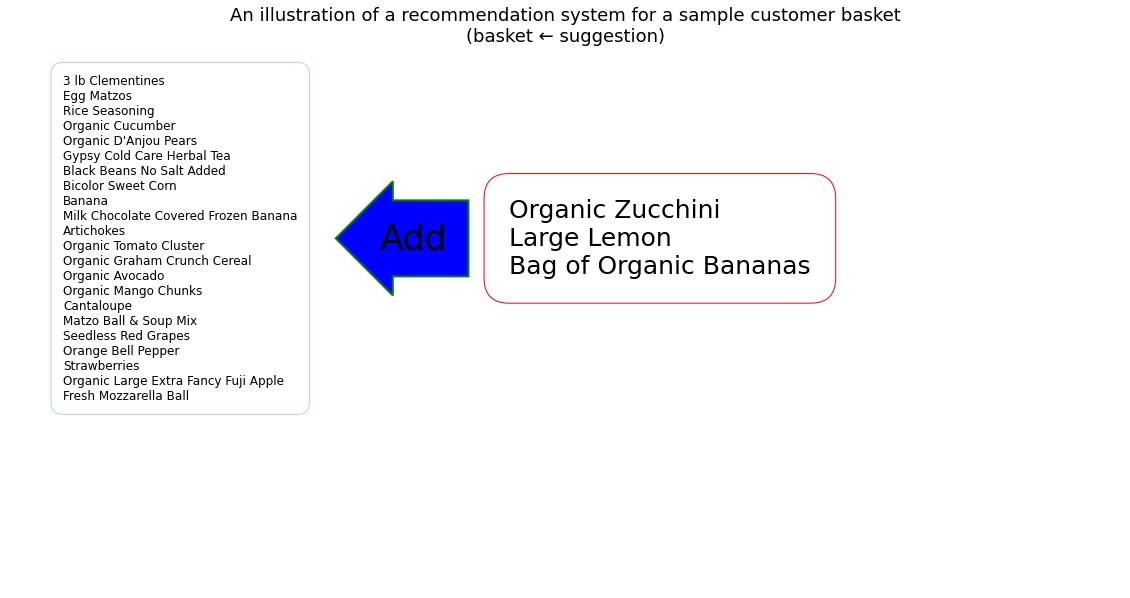

In [34]:
sample_index = np.random.randint(len(non_empty_recs))
sample_basket = "\n".join(non_empty_recs.iloc[sample_index].loc["basket"])
sample_recommendation = "\n".join(non_empty_recs.iloc[sample_index].loc["recommendations"])
mba_diagram(sample_basket, sample_recommendation)

In [30]:
truth_table

,1,2,3,4,5,7,8,9,10,11,...,49677,49678,49679,49680,49681,49682,49683,49686,49687,49688
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
36,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
38,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
96,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
98,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3421049,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3421056,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3421058,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3421063,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
